# Explore x-ray data and create DICOM images

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

import os
from glob import glob

from datetime import datetime

In [2]:
import pydicom
import SimpleITK as sitk # from solutions

print(f"pydicom: {pydicom.__version__}")
print(f"sitk:    {sitk.__version__}")

pydicom: 2.1.2
sitk:    2.0.2


In [3]:
start_time = datetime.now()

In [4]:
#!conda install opencv -c conda-forge

In [5]:
#conda install pydicom

In [6]:
#conda install -c simpleitk simpleitk

In [7]:
!ls

COVID-19_Radiography_Database.zip dicom_ct
COVID-19_Radiography_Dataset      dicom_xray
COVID-CT-master                   wk1_vgg16_xray_prep.ipynb
COVID-CT-master.zip               xray_dataset.csv
Project1_MS1_part1.ipynb          xray_dataset_full.csv


In [8]:
#!ls COVID-19_Radiography_Dataset/Lung_Opacity/

## 1. Load the XRAY image dataset, define paths to the datasets, including path to COVID and Non-COVID data.

In [9]:
dir_covid  =  './COVID-19_Radiography_Dataset/COVID'
dir_pneum  = r'./COVID-19_Radiography_Dataset/Viral Pneumonia/'
dir_normal =  './COVID-19_Radiography_Dataset/Normal'
dir_lung   =  './COVID-19_Radiography_Dataset/Lung_Opacity/'


In [10]:
covid_files = [dir_covid + '/' + x for x in os.listdir(dir_covid)]
pneum_files = [dir_pneum + '/' + x for x in os.listdir(dir_pneum)]
normal_files = [dir_normal + '/' + x for x in os.listdir(dir_normal)]
lung_files   = [dir_lung   + '/' + x for x in os.listdir(dir_lung)]
print(f"covid: {len(covid_files)} normal:{len(normal_files)} total: {len(covid_files)+len(normal_files)}")
covid_files[:2]

covid: 3616 normal:10192 total: 13808


['./COVID-19_Radiography_Dataset/COVID/COVID-1.png',
 './COVID-19_Radiography_Dataset/COVID/COVID-1175.png']

In [11]:
dict_all = {'file':covid_files+normal_files}

In [12]:
df = pd.DataFrame(dict_all,columns=['file'])
df['has_covid'] = df.apply(lambda x: 0 if 'Normal' in x['file'] else 1, axis=1)
df.set_index(['file'],inplace=True)

In [13]:
# sanity check the counts
print(df.shape)
df['has_covid'].sum()

(13808, 1)


3616

In [14]:
df.head(3)

,has_covid
file,
./COVID-19_Radiography_Dataset/COVID/COVID-1.png,1
./COVID-19_Radiography_Dataset/COVID/COVID-1175.png,1
./COVID-19_Radiography_Dataset/COVID/COVID-1613.png,1


In [15]:
df.tail(3)

,has_covid
file,
./COVID-19_Radiography_Dataset/Normal/Normal-4798.png,0
./COVID-19_Radiography_Dataset/Normal/Normal-7291.png,0
./COVID-19_Radiography_Dataset/Normal/Normal-1838.png,0


## 2. Open and display a random set of 9 images (COVID and non-COVID) from the XRAY image dataset.

In [16]:
covid_9 = np.random.choice(covid_files,9,replace=False)
normal_9 = np.random.choice(normal_files,9,replace=False)
pneum_9 = np.random.choice(pneum_files,9,replace=False)
lung_9 = np.random.choice(lung_files,9,replace=False)

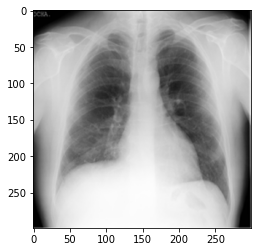

In [17]:
img=cv2.imread(covid_9[0])
plt.imshow(img)

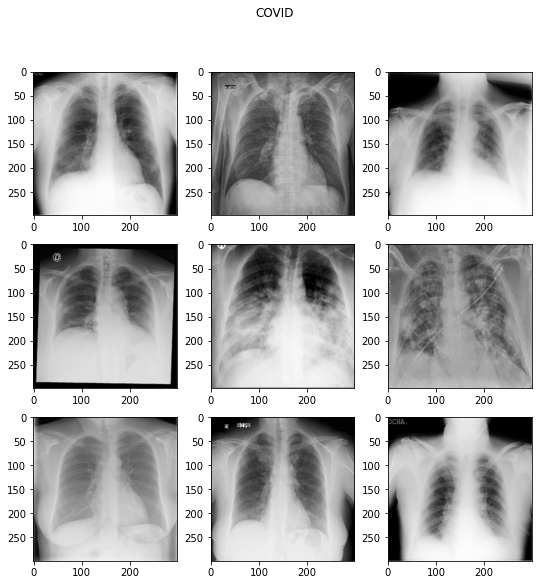

In [18]:
fig = plt.figure(figsize=(9,9))

axes = []
for idx,f in enumerate(covid_9):
    ax = fig.add_subplot(3,3,idx+1)
    axes.append(ax)
    img = cv2.imread(f)
    plt.imshow(img)
plt.suptitle('COVID');

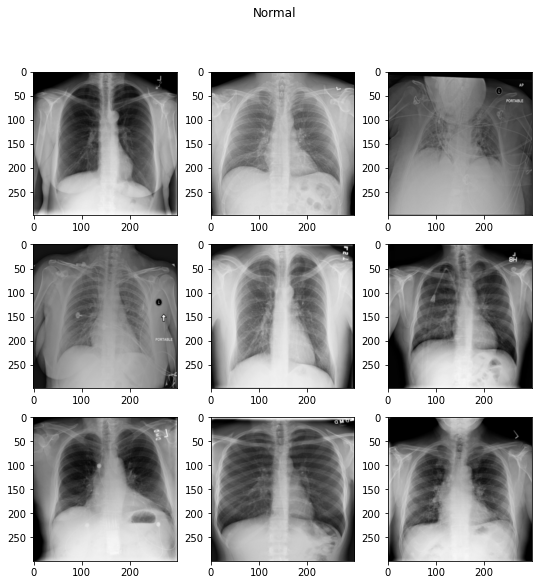

In [19]:
fig = plt.figure(figsize=(9,9))

axes = []
for idx,f in enumerate(normal_9):
    ax = fig.add_subplot(3,3,idx+1)
    axes.append(ax)
    img = cv2.imread(f)
    plt.imshow(img)
plt.suptitle('Normal');

## 3. Resize all images to 224x224 pixels.

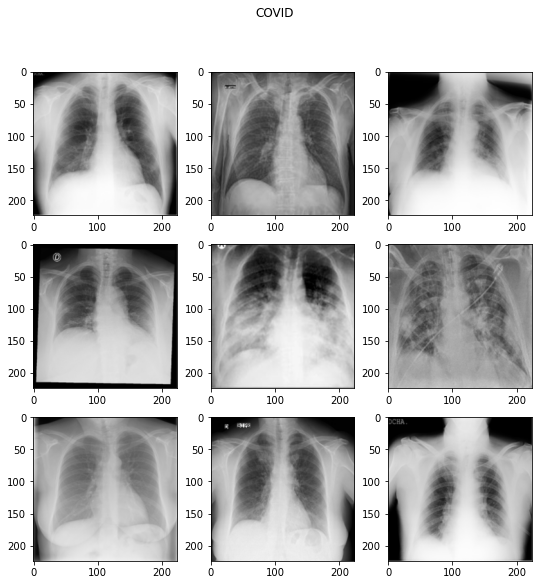

In [20]:
fig = plt.figure(figsize=(9,9))

axes = []
for idx,f in enumerate(covid_9):
    ax = fig.add_subplot(3,3,idx+1)
    axes.append(ax)
    img = cv2.imread(f)
    img2 = cv2.resize(img,(224,224))
    plt.imshow(img2)
plt.suptitle('COVID');

## 4. Plot label distribution of images- that is how many images per label for XRAY image dataset.

<AxesSubplot:>

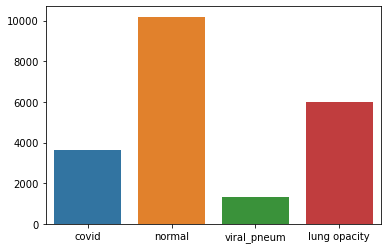

In [21]:
sns.barplot(x=['covid','normal','viral_pneum','lung opacity'], 
            y=[len(covid_files),len(normal_files),len(pneum_files),len(lung_files)])

## 5. Estimate image statistics- mean, max, min, standard deviation of pixel values in X-ray images.

In [22]:
def plot_9(flist,title):
    fig = plt.figure(figsize=(12,12))

    axes = []
    for idx,f in enumerate(covid_9):
        ax = fig.add_subplot(3,3,idx+1)
        axes.append(ax)
        img = cv2.imread(f)
        img2 = cv2.resize(img,(224,224))


        plt.imshow(img2)
        plt.title(f"min:{np.min(img2)} max:{np.max(img2)} mean:{int(np.mean(img2))} std:{int(np.std(img2))}")
    plt.suptitle(title);

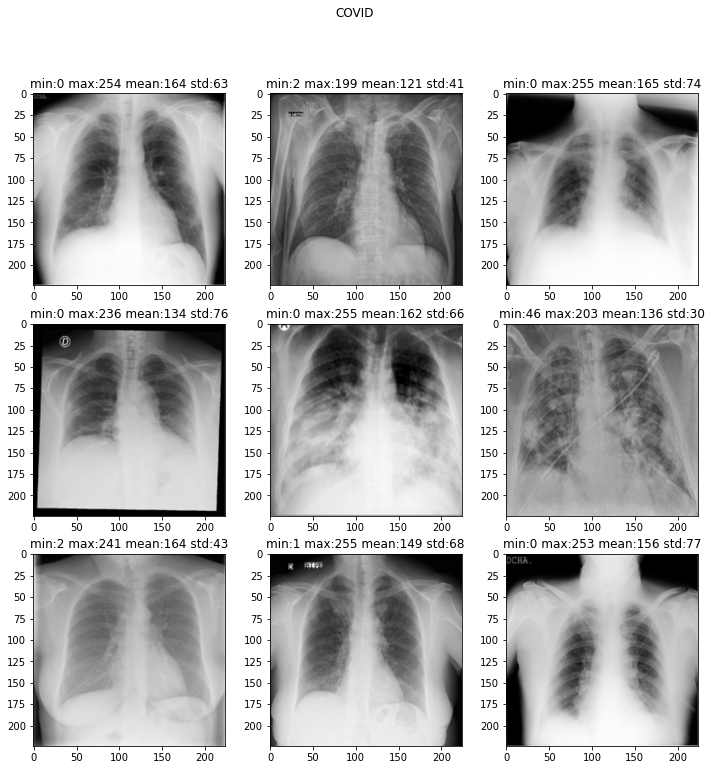

In [23]:
plot_9(covid_9,'COVID')

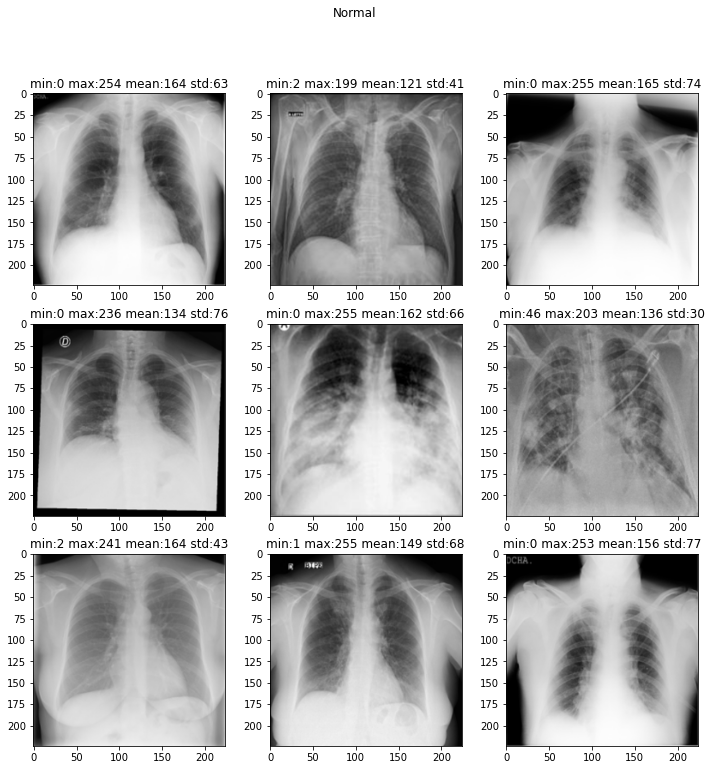

In [24]:
plot_9(normal_9,'Normal')

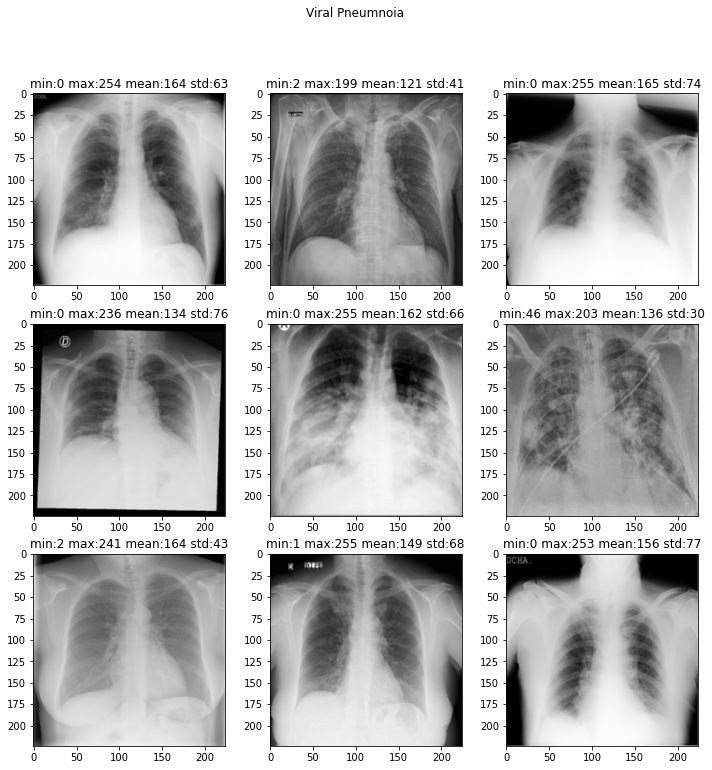

In [25]:
plot_9(pneum_9,'Viral Pneumnoia')

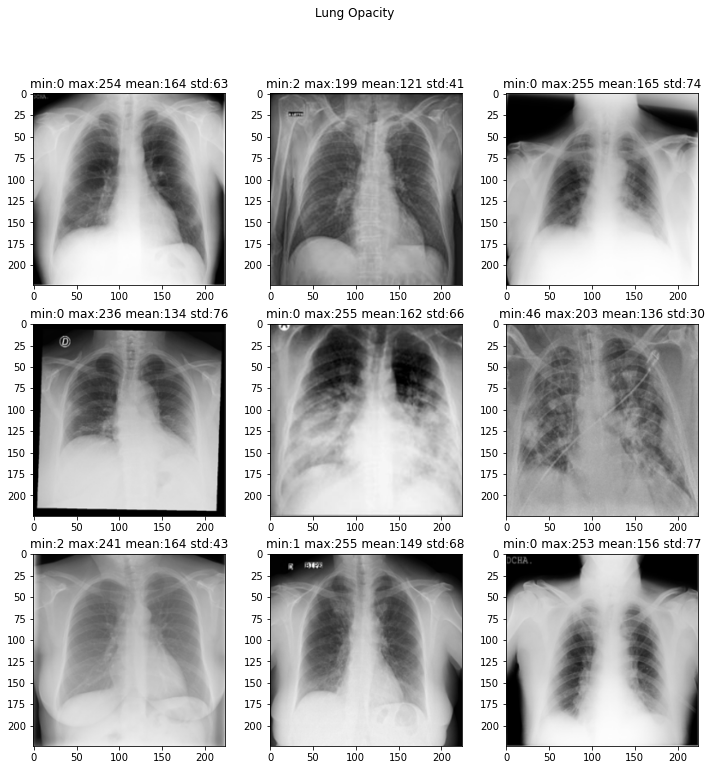

In [26]:
plot_9(lung_9,'Lung Opacity')

## 6. Plot histogram of image intensities for COVID and Non-COVID images from the XRAY image dataset.

In [27]:
def plot_pair9_hist(flist,title):
    fig = plt.figure(figsize=(12,18))
    
    combined_hist = np.zeros((256,1))

    axes = []
    for idx,f in enumerate(flist):
        print(f"f is {f}")
        
        ax = fig.add_subplot(9,2,(2*idx)+1)
        axes.append(ax)
        img = cv2.imread(f)
        img2 = cv2.resize(img,(224,224))


        plt.imshow(img2)
        plt.title(f"min:{np.min(img2)} max:{np.max(img2)} mean:{int(np.mean(img2))} std:{int(np.std(img2))}")
        
        ax = fig.add_subplot(9,2,(2*idx)+2)
        img_hist = cv2.calcHist(img2,[0],None,[256],[0,256])
        combined_hist = combined_hist + img_hist
        plt.plot(img_hist)
    plt.suptitle(title);
    
    return combined_hist

f is ./COVID-19_Radiography_Dataset/COVID/COVID-3568.png
f is ./COVID-19_Radiography_Dataset/COVID/COVID-644.png
f is ./COVID-19_Radiography_Dataset/COVID/COVID-2647.png
f is ./COVID-19_Radiography_Dataset/COVID/COVID-1492.png
f is ./COVID-19_Radiography_Dataset/COVID/COVID-1565.png
f is ./COVID-19_Radiography_Dataset/COVID/COVID-1482.png
f is ./COVID-19_Radiography_Dataset/COVID/COVID-1687.png
f is ./COVID-19_Radiography_Dataset/COVID/COVID-3611.png
f is ./COVID-19_Radiography_Dataset/COVID/COVID-1890.png


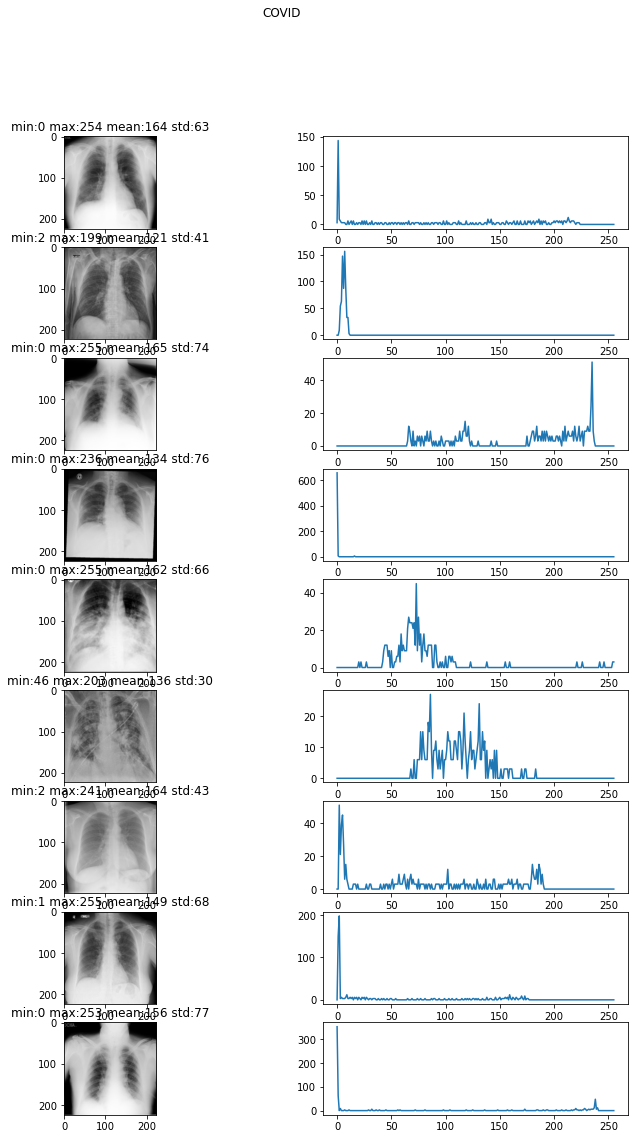

In [28]:
covid_hist = plot_pair9_hist(covid_9,'COVID')

f is ./COVID-19_Radiography_Dataset/Normal/Normal-4600.png
f is ./COVID-19_Radiography_Dataset/Normal/Normal-9129.png
f is ./COVID-19_Radiography_Dataset/Normal/Normal-2345.png
f is ./COVID-19_Radiography_Dataset/Normal/Normal-9036.png
f is ./COVID-19_Radiography_Dataset/Normal/Normal-1984.png
f is ./COVID-19_Radiography_Dataset/Normal/Normal-7704.png
f is ./COVID-19_Radiography_Dataset/Normal/Normal-1849.png
f is ./COVID-19_Radiography_Dataset/Normal/Normal-1478.png
f is ./COVID-19_Radiography_Dataset/Normal/Normal-3449.png


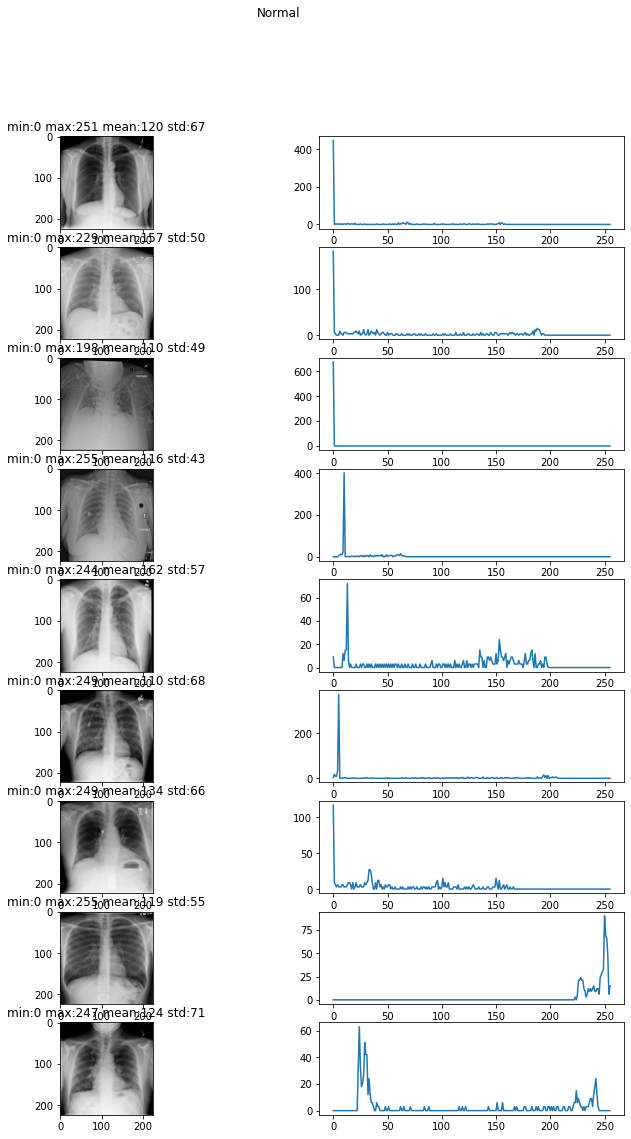

In [29]:
no_covid_hist = plot_pair9_hist(normal_9,'Normal')

## 7. Compare histograms of COVID and Non-COVID images. How do they differ? What information do you get from the histograms?


Individual histograms are difficult to use for drawing general conclusions. If I average 9 randomly selected histograms (those plotted above), then it looks like COVID patients have a larger number of mid-range pixels.

(0.0, 80.0)

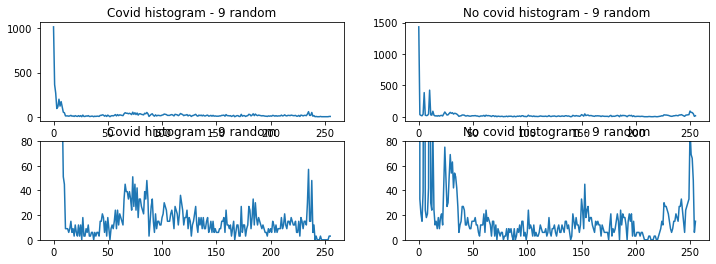

In [30]:
fig = plt.figure(figsize=(12,4))
# full scale versions show large spike at 0 (black pixels -- often the space around the body)
ax1 = fig.add_subplot(2,2,1)
plt.plot(covid_hist)
plt.title("Covid histogram - 9 random")
ax2 = fig.add_subplot(2,2,2)
plt.plot(no_covid_hist)
plt.title("No covid histogram - 9 random")

limit_y = 80
ax3 = fig.add_subplot(2,2,3)
plt.plot(covid_hist)
plt.title("Covid histogram - 9 random")
plt.ylim(0,limit_y)
ax4 = fig.add_subplot(2,2,4)
plt.plot(no_covid_hist)
plt.title("No covid histogram - 9 random")
plt.ylim(0,limit_y)

## 8. Convert all images from the COVID and Non-COVID directories in DICOM (.dcm) format.

### One way - pydicom

...but this would be very messy. I would need to open a blank image and stuff in the values in order for the data to be in the correct format.

In [31]:
covid_files[:2]

['./COVID-19_Radiography_Dataset/COVID/COVID-1.png',
 './COVID-19_Radiography_Dataset/COVID/COVID-1175.png']

### Another way! - SimpleITK

Very interesting discovery! I didn't see this in any of the project resources, though, and had to go look at the solution to find it.

In [32]:
# Copied and adapted from the project solution "Project1_MS1_part1.ipynb"

def convert_to_dcm(file_list, index_start, destination_prefix):
    count = 0
    idx = index_start
    dict_name_pairs = dict()
    
    for image in file_list:
        im1 = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
        #im1 = cv2.resize(im1,(224,224)) # unclear if this is needed -- project example didn't do this on export
        im1= np.array(im1)
        img= sitk.GetImageFromArray(im1)
        img = sitk.GetImageFromArray(im1)
        dicom_fname = destination_prefix + str(idx)+'.dcm'
        sitk.WriteImage(img, dicom_fname)
        idx = idx + 1
        count = count+1
        
        dict_name_pairs[image] = dicom_fname
    return count, idx, dict_name_pairs

### Covid examples

In [33]:
covid_count, total_covid, covid_pairs = convert_to_dcm(covid_files,0,'./dicom_xray/covid/covidchest_')   
print(f"{covid_count} images from the covid xrays")
print(f"{total_covid} images in this folder")

3616 images from the covid xrays
3616 images in this folder


### Non-covid examples

In [34]:
noncovid_count = 0 # use this for a running tally and to index everything sequentially

In [35]:
normal_count, noncovid_count, norm_pairs = convert_to_dcm(normal_files,noncovid_count,'./dicom_xray/no_covid/nocovidchest_')   
print(f"{normal_count} images from the normal xrays")
print(f"{noncovid_count} images in this folder")

10192 images from the normal xrays
10192 images in this folder


In [36]:
pneum_count, noncovid_count, pneum_pairs = convert_to_dcm(pneum_files,noncovid_count,'./dicom_xray/no_covid/nocovidchest_')   
print(f"{pneum_count} images from the viral pneumonia xrays")
print(f"{noncovid_count} images in this folder")

1345 images from the viral pneumonia xrays
11537 images in this folder


In [37]:
lung_count, noncovid_count, lung_pairs = convert_to_dcm(lung_files,noncovid_count,'./dicom_xray/no_covid/nocovidchest_')   
print(f"{pneum_count} images from the viral pneumonia xrays")
print(f"{noncovid_count} images in this folder")

1345 images from the viral pneumonia xrays
17549 images in this folder


In [38]:
# Unclear if I'll want all of these types of non-covid images, but I'll start with this
print(f"Total COVID xrays: {covid_count}\n")

print(f"normal:      {normal_count}")
print(f"pneumonia:   {pneum_count}")
print(f"opaque lung: {lung_count}")
print(f"Total non-COVID xrays: {noncovid_count}\n")

Total COVID xrays: 3616

normal:      10192
pneumonia:   1345
opaque lung: 6012
Total non-COVID xrays: 17549



### confirm valid dcm file

In [39]:
fpath = './dicom_xray/no_covid/nocovidchest_0.dcm'
ds = pydicom.dcmread(fpath)

In [40]:
print(ds) # Discovered that I didn't convert images before export -- had to go back

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 254
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.2.1125.1.86289234001701270385004261653214352
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.826.0.1.3680043.2.1143.107.104.103.115.3.0.5.111.124.113
(0002, 0013) Implementation Version Name         SH: 'GDCM 3.0.5'
(0002, 0016) Source Application Entity Title     AE: 'GDCM/ITK 5.1.2'
-------------------------------------------------
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.826.0.1.3680043.2.1125.1.86289234001701270385004261653214352
(0008, 0020) Study Date                    

## 9. Save all file paths with their class labels to a CSV file.

### opt for new dataframe with full info

In [41]:
dict_all = {'file':covid_files + normal_files + pneum_files + lung_files}
df2 = pd.DataFrame(dict_all,columns=['file'])
df2['has_covid'] = df2.apply(lambda x: 1 if 'COVID' in x['file'] else 0, axis=1)

In [42]:
df2.head(3)

,file,has_covid
0,./COVID-19_Radiography_Dataset/COVID/COVID-1.png,1
1,./COVID-19_Radiography_Dataset/COVID/COVID-117...,1
2,./COVID-19_Radiography_Dataset/COVID/COVID-161...,1


In [43]:
all_pairs = covid_pairs
all_pairs.update(norm_pairs)
all_pairs.update(pneum_pairs)
all_pairs.update(lung_pairs)

In [44]:
df2['dcm_file'] = df2.apply(lambda x: all_pairs[x['file']], axis=1)

In [45]:
df2.head(3)

,file,has_covid,dcm_file
0,./COVID-19_Radiography_Dataset/COVID/COVID-1.png,1,./dicom_xray/covid/covidchest_0.dcm
1,./COVID-19_Radiography_Dataset/COVID/COVID-117...,1,./dicom_xray/covid/covidchest_1.dcm
2,./COVID-19_Radiography_Dataset/COVID/COVID-161...,1,./dicom_xray/covid/covidchest_2.dcm


In [46]:
df2.to_csv('xray_dataset_full.csv',index=False)

### export a mini version to match the project example

In [47]:
df2[['dcm_file','has_covid']].to_csv('xray_dataset.csv',index=False)

### note time

In [48]:
finish_time = datetime.now()
print(f"start:  {start_time}")
print(f"finish: {finish_time}")

start:  2021-05-30 10:44:51.117149
finish: 2021-05-30 10:45:46.399255
